# Problem Session 10
## Concrete Compressive Strength I:  Ensemble Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

##### 1. 

We will work with the following dataset:

Yeh,I-Cheng. (2007). Concrete Compressive Strength. UCI Machine Learning Repository. https://doi.org/10.24432/C5PK67.

1. Print the ReadMe file and read the variable descriptions.  The file is `Concrete_readme.txt` in this directory.
2. Load the data as a pandas DataFrame. The data is located in `../../data/concrete.csv`.
    * Note:  the last column `Concrete compressive strength(MPa, megapascals)` is our target variable and the rest are features.
3. Make a train/test split.
4. Use `sns.pairplot` to visualize the relationship between each feature and the target.
    * Discussion question:  which of the following should you use for this visualization and why?
        * The full dataset
        * The training set
        * The testing set

In [2]:
#1.

with open('Concrete_Readme.txt') as readme:
    print(readme.read())

Concrete Compressive Strength 

---------------------------------

Data Type: multivariate
 
Abstract: Concrete is the most important material in civil engineering. The 
concrete compressive strength is a highly nonlinear function of age and 
ingredients. These ingredients include cement, blast furnace slag, fly ash, 
water, superplasticizer, coarse aggregate, and fine aggregate.

---------------------------------

Sources: 

  Original Owner and Donor
  Prof. I-Cheng Yeh
  Department of Information Management 
  Chung-Hua University, 
  Hsin Chu, Taiwan 30067, R.O.C.
  e-mail:icyeh@chu.edu.tw
  TEL:886-3-5186511

  Date Donated: August 3, 2007
 
---------------------------------

Data Characteristics:
    
The actual concrete compressive strength (MPa) for a given mixture under a 
specific age (days) was determined from laboratory. Data is in raw form (not scaled). 

Summary Statistics: 

Number of instances (observations): 1030
Number of Attributes: 9
Attribute breakdown: 8 quantitat

In [3]:
#2.
df = pd.read_csv('../../data/concrete.csv')

#3.
## make a train test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, 
                                                    shuffle=True,
                                                    random_state=216,
                                                    test_size=.2)

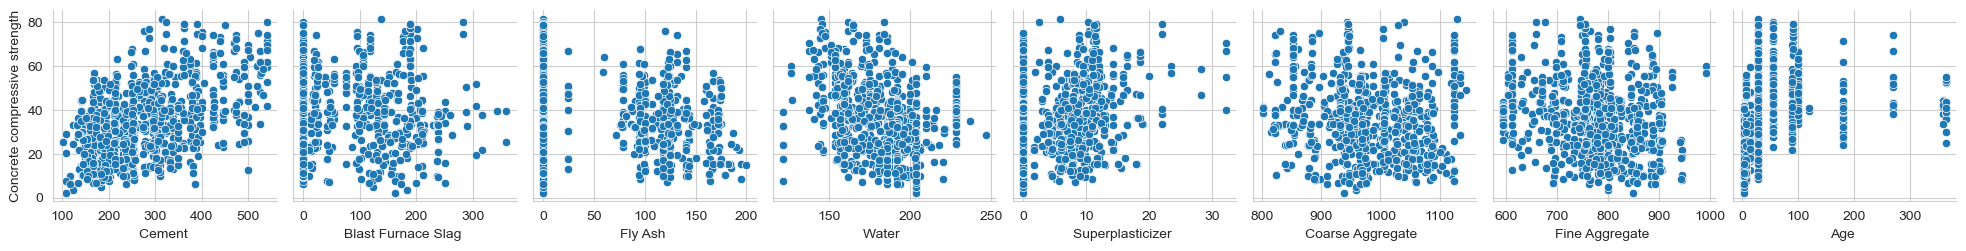

In [4]:
#4.

features = df.columns[:-1]
target = df.columns[-1]

g = sns.pairplot(df_train, x_vars=features, y_vars=target)
names = df.columns.map(lambda t: t.split('(')[0])
for i in range(8):
    g.axes[0,i].xaxis.set_label_text(names[i])
    g.axes[0,i].yaxis.set_label_text(names[8])
plt.show()

#### 2a.

In this problem we are removing the usual scaffolding that we supply in the problem sessions!

Write your own the code below to find the values of `max_depth` and `n_estimators` for a either a Random Forest Regressor or an Extra Trees Regressor with the lowest average cross-validation RMSE.

Your code should accomplish the following:
1. Make a stratified 5-fold split of the training data.
2. Select `max_depth` from `range(1,11)`  and `n_estimators` from the two choices `[100,500]` to minimize cross validation RMSE.

Try not to copy/paste from earlier problem sessions:  talk through the logic and write your own cross-validation loop.

Some further questions to consider when training a random forest regressors:

* Is scaling necessary as a preprocessing step?  Why or why not?
* Does colinearity of features matter?
* Should you do feature selection first?
* What bias/variance impact do you think increasing `n_estimators` or `max_depth` will have on the model?
* How might you decide whether to use Random Forest or Extra Trees?


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Extract features and target from the training DataFrame.
X_train = df_train[features]
y_train = df_train[target]

# Define the parameter ranges.
max_depths = range(1, 11)            # 1 to 10 inclusive
n_estimators_options = [100, 500]

# Shape: (number of max_depth options, number of n_estimators options) = (10, 2)
rmse_arr = np.zeros((len(max_depths), len(n_estimators_options)))

# Set up 5-fold cross-validation.
kf = KFold(n_splits=5, shuffle=True, random_state=216)

# Loop over all combinations of max_depth and n_estimators.
for i, max_depth in enumerate(max_depths):
    for j, n_estimators in enumerate(n_estimators_options):
        fold_rmse = []  # To store RMSE for each fold.
        
        # Perform cross-validation.
        for train_index, test_index in kf.split(X_train):
            # If X is a DataFrame, you can index directly.
            X_tt, X_ho = X_train.iloc[train_index], X_train.iloc[test_index]
            y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]
            
            # Instantiate and train the regressor.
            model = RandomForestRegressor(max_depth=max_depth, 
                                          n_estimators=n_estimators, 
                                          random_state=216)
            model.fit(X_tt, y_tt)
            
            # Predict and compute RMSE for this fold.
            y_pred = model.predict(X_ho)
            rmse = np.sqrt(mean_squared_error(y_ho, y_pred))
            fold_rmse.append(rmse)
        
        # Store the average RMSE for the current parameter combination.
        rmse_arr[i, j] = np.mean(fold_rmse)

print("Average cross-validation RMSEs for each combination:")
print(rmse_arr)

# To get the best parameters:
best_idx = np.unravel_index(np.argmin(rmse_arr), rmse_arr.shape)
best_max_depth = list(max_depths)[best_idx[0]]
best_n_estimators = n_estimators_options[best_idx[1]]
print(f"Best parameters: max_depth={best_max_depth}, n_estimators={best_n_estimators}")

Average cross-validation RMSEs for each combination:
[[13.76298894 13.6807195 ]
 [11.24132093 11.19085709]
 [ 9.53395551  9.52294739]
 [ 8.02901239  8.0330732 ]
 [ 7.02713148  7.00630734]
 [ 6.41609701  6.41218625]
 [ 6.05057309  6.02767342]
 [ 5.82662785  5.78354835]
 [ 5.67206309  5.63151711]
 [ 5.58483524  5.53402225]]
Best parameters: max_depth=10, n_estimators=500


##### b.

In this problem you will learn about `GridSearchCV`, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html</a>, a handy class from `sklearn` that makes hyperparameter tuning through a grid search and cross-validation quicker to code up than writing out a series of `for` loops.


Read through the code chunks below and fill in the missing code to run the same grid search cross-validation you did above with `GridSearchCV`.

In [6]:
## first import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
## This will also take 1-2 minutes to run
grid_cv = GridSearchCV(RandomForestRegressor(), # first put the model object here
                          param_grid = {'max_depth':range(1, 11), # place the grid values for max_depth and
                                        'n_estimators':[100,500]}, # and n_estimators here
                          scoring = 'neg_root_mean_squared_error', # put the score we are trying to optimize here as a string, 'neg_root_mean_squared_error'
                                      # Note that "score" is the opposite of "loss":  bigger score is better.
                          cv = 5) # put the number of cv splits here

## you fit it just like a model
grid_cv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 11), 'n_estimators': [100, 500]},
             scoring='neg_root_mean_squared_error')

Once a `GridSearchCV` is fit you are easily able to find what hyperparameter combinations were best, what the optimal score was as well as get access to the best model.

In [8]:
## You can find the hyperparameter grid point that
## gave the best performance like so
## .best_params_
grid_cv.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [ ]:
## You can find the best score like so
## .best_score_
grid_cv.best_score_

np.float64(-5.455668280386737)

In [10]:
## Calling best_estimator_ returns the model with the 
## best avg cv performance after it has been refit on the
## entire data set
grid_cv.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=500)

The `best_estimator_` is a model with the optimal hyperparameters that has been fit on the entire training set. Try and predict the compressive strength on the training set with the `best_estimator_` below.

In [11]:
## code here
grid_cv.best_estimator_.predict(X_train)


array([13.93113316, 13.71691825, 56.3601775 , 27.93874365, 31.4294441 ,
       28.54213154, 57.25371154, 52.72636421, 40.17059952, 61.27854156,
       38.09914953, 34.87661807, 30.66288971,  8.74577098, 38.17867452,
       29.92623354, 38.20406688, 41.51675379, 35.01338776, 51.88076633,
       48.66793466, 10.56455096, 72.23118732, 29.32066249, 33.45196679,
       26.73879871, 54.33605859, 29.77799638, 28.59196218, 12.95594036,
       50.01049023, 32.49703553, 24.8483213 , 33.62390215, 32.3205473 ,
       44.24864023, 36.67431749, 72.37452696, 15.94993329, 25.87203979,
       12.75773947, 48.04417308, 35.06945009, 23.05733013, 38.14466487,
       15.71029747, 57.3291138 , 26.50534344, 62.35180438, 38.46867196,
       58.80847471, 21.61243938, 24.01100044, 25.29806479, 48.42945389,
       10.83463585, 13.08550923, 45.32830305, 14.69914387, 19.74358535,
       50.38070877, 51.53744333, 37.26228704, 69.15950533, 55.3263663 ,
       59.55101383, 60.28115553, 14.44427932, 30.48967484, 42.07

If you want to look at all of the results, you can do that as well with `.cv_results`. Try that below.

In [12]:
## You can get all of the results with cv_results_
grid_cv.cv_results_

{'mean_fit_time': array([0.05634174, 0.28592129, 0.07083173, 0.34895439, 0.08846903,
        0.42051177, 0.09715791, 0.48249884, 0.11019874, 0.54456143,
        0.12156563, 0.60091558, 0.13225417, 0.65667753, 0.14443302,
        0.70929508, 0.15372872, 0.75663629, 0.157936  , 0.79440203]),
 'std_fit_time': array([0.00165238, 0.00617858, 0.00019893, 0.00034121, 0.00452607,
        0.0078313 , 0.00032876, 0.00172324, 0.00153701, 0.00459251,
        0.00072376, 0.00164623, 0.00027058, 0.00262763, 0.00446717,
        0.00204268, 0.0051066 , 0.00909808, 0.00081458, 0.01006943]),
 'mean_score_time': array([0.00390196, 0.01539693, 0.00372772, 0.0154108 , 0.00493803,
        0.01574521, 0.00401764, 0.01706123, 0.00418038, 0.01781921,
        0.0043282 , 0.01870561, 0.00447493, 0.01978126, 0.00476918,
        0.02092757, 0.0049542 , 0.02177277, 0.00520082, 0.02272491]),
 'std_score_time': array([1.06940447e-04, 1.24247111e-04, 7.16904330e-05, 1.06535986e-04,
        1.31697006e-03, 7.85671932e-

##### c.

Using either the `best_estimator_` fitted model or a refitted model according to your results from the `for` loop cross-validation find the feature importance scores.

In [13]:
## code here
feature_importance_df = pd.DataFrame({
    'Feature': features,  # List of feature names
    'Importance': grid_cv.best_estimator_.feature_importances_
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Reset index for better readability
feature_importance_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(feature_importance_df)

                                             Feature  Importance
0                                          Age (day)    0.336670
1          Cement (component 1)(kg in a m^3 mixture)    0.324821
2          Water  (component 4)(kg in a m^3 mixture)    0.103978
3  Blast Furnace Slag (component 2)(kg in a m^3 m...    0.082542
4  Superplasticizer (component 5)(kg in a m^3 mix...    0.067931
5  Fine Aggregate (component 7)(kg in a m^3 mixture)    0.035900
6  Coarse Aggregate  (component 6)(kg in a m^3 mi...    0.027938
7         Fly Ash (component 3)(kg in a m^3 mixture)    0.020220


#### 5. Bagging one of the previous models

Consider the following regression algorithms:

* kNN with $k=2$
* kNN with $k=100$
* Linear Regression
* Support Vector Regressor using RBF kernel and $\gamma = 0.1$
* Support Vector Regressor using RBF kernel and $\gamma = 10$

Of these which are likely to benefit from bagging, if any?

Choose one algorithm which you think could be improved by bagging and compare cross-validation RMSE of the base model and the bagged model.  Did bagging improve performance?  


Bagging benefits models which are prone to over-fitting, like kNN with low k or SVR with $\gamma$ large (aka $\sigma^2$ low).  It doesn't benefit the other models listed since they are not prone to over-fitting.  Let's bag the kNN with $k=2$.

In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Extract features and target
X = df_train[features]
y = df_train[target]

# Define the base kNN regressor with k=2
base_knn = KNeighborsRegressor(n_neighbors=2)

# Define the bagging regressor with 100 estimators
bagged_knn = BaggingRegressor(
    estimator=base_knn,
    n_estimators=100,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store RMSE for each fold
rmse_scores_base = []
rmse_scores_bagged = []

# Perform cross-validation
for train_index, test_index in kf.split(X_train):
    X_tt, X_ho = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the bagged kNN model
    base_knn.fit(X_tt, y_tt)
    bagged_knn.fit(X_tt, y_tt)
    
    # Predict on the validation set
    y_pred_base = base_knn.predict(X_ho)
    y_pred_bagged = bagged_knn.predict(X_ho)
    
    # Compute RMSE
    rmse_base = np.sqrt(mean_squared_error(y_ho, y_pred_base))
    rmse_scores_base.append(rmse_base)
    rmse_bagged = np.sqrt(mean_squared_error(y_ho, y_pred_bagged))
    rmse_scores_bagged.append(rmse_bagged)

# Compute mean and standard deviation of RMSE across folds
mean_rmse_base = np.mean(rmse_scores_base)
mean_rmse_bagged = np.mean(rmse_scores_bagged)

# Print results
print(f"Base Cross-Validation RMSE: {mean_rmse_base:.4f}")
print(f"Bagged Cross-Validation RMSE: {mean_rmse_bagged:.4f}")

Base Cross-Validation RMSE: 9.1864
Bagged Cross-Validation RMSE: 8.6893


#### 3.  Write your own Bagging Regressor class  

Write your own BaggingRegressor class:

In [15]:
import numpy as np

class CustomBaggingRegressor:
    '''
    Trains a sequence of regressors on bootstrap resamples of the training data.
    Prediction is performed by taking the mean of the predictions of all regressors.
    This is only designed to work with MSE loss.
    '''
    def __init__(self, base_estimator, num_estimators=10, kwargs=None):
        '''
        Parameters:
            base_estimator: A regression class (e.g., from scikit-learn).
            num_estimators: The number of estimators in the ensemble.
            kwargs: A dictionary of keyword arguments to pass to the estimators.
        
        Attributes:
            self.estimators: A list of instantiated base estimators.
        '''
        self.kwargs = kwargs if kwargs is not None else {}
        self.num_estimators = num_estimators
        self.estimators = [base_estimator(**self.kwargs) for _ in range(num_estimators)]
    
    def fit(self, X, y):
        '''
        Parameters:
            X: numpy array of shape (n, p), where n is the number of samples.
            y: numpy array of shape (n,) or (n, 1), target values.
        '''
        rng = np.random.default_rng()
        n_samples = X.shape[0]
        for estimator in self.estimators:
            # Generate bootstrap indices (sampling rows, axis=0)
            indices = rng.choice(n_samples, size=n_samples, replace=True)
            X_boot = X[indices]
            y_boot = y[indices]
            estimator.fit(X_boot, y_boot)
    
    def predict(self, X):
        '''
        Predict using the ensemble by averaging predictions from all estimators.

        Parameters:
            X: numpy array of shape (n, p)
        
        Returns:
            preds: numpy array of shape (n,), the aggregated predictions.
        '''
        # Collect predictions from each estimator and take their mean
        preds = np.mean([estimator.predict(X) for estimator in self.estimators], axis=0)
        return preds


In [18]:
# Make sure that your class is able to run the following code.
# Does increasing the number of estimators decrease the MSE?

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

X = np.random.normal(size = (100,2))
y = X[:,0]**2 + X[:,0]*X[:,1]

model =  CustomBaggingRegressor(
            base_estimator = DecisionTreeRegressor, 
            num_estimators = 1, # try 1 and 10 a bunch of times.
            kwargs = {'max_depth' : 10}
            )

model.fit(X,y)

mean_squared_error(y, model.predict(X))

0.534293001360783

--------------------------

This notebook was written for the Erd&#337;s Institute Data Science Boot Camp by Steven Gubkin, 2025.